In [ ]:
#!/usr/bin/env python
# coding: utf-8

# Load packages

In [ ]:
from IPython import get_ipython

In [ ]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

/srv/data/robinve/miniconda3/envs/latenta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## unpack the data

In [ ]:
with open("../../real_data/wild_type_cells.pkl", "rb") as f:
    adata = pickle.load(f)

In [ ]:
base_model = create_base_model(adata, definition_type=object)

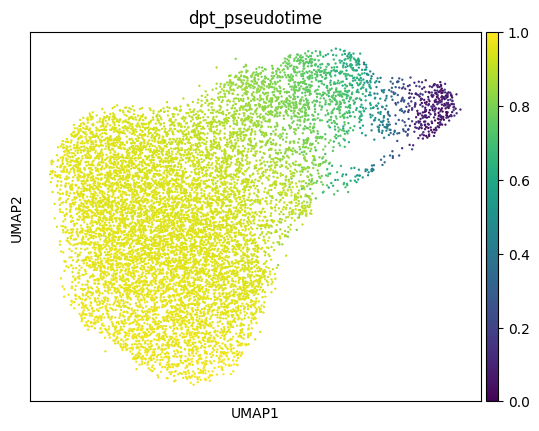

In [ ]:
# Identify root and endpoint cell clusters (manually from the PAGA plot)
root_cluster = '5'  # Example cluster ID for the root
end_cluster = '0'  # Example cluster ID for the endpoint

# Select a representative cell from each cluster
root_cell = adata.obs[adata.obs['leiden'] == root_cluster].index[0]
end_cell = adata.obs[adata.obs['leiden'] == end_cluster].index[0]

# Set the root and endpoint cells
adata.uns['iroot'] = adata.obs_names.get_loc(root_cell)
adata.uns['iend'] = adata.obs_names.get_loc(end_cell)
# Compute pseudotime with DPT
sc.tl.dpt(adata, n_dcs=5)


sc.pl.umap(adata, color=["dpt_pseudotime"])

In [ ]:
def map_nested_fn(fn):
    """Recursively apply `fn` to key-value pairs of a nested dict."""
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [ ]:
@map_nested_fn
def label_fn(k, v):
    # print(k)
    if ("kernel" in k) or ("bias" in k):
        return "a"
    else:
        return "b"

In [ ]:
optimizer = optax.multi_transform({"b": optax.adam(5e-3), "a": optax.adam(1e-4)}, label_fn)

In [ ]:
adata.X = adata.X.toarray()
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.7578579 ],
       [0.        , 0.        , 0.28291035, ..., 0.        , 0.        ,
        0.6835809 ],
       [0.        , 0.        , 0.6585069 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.67586887, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
pca,cells,X =adata_pca(adata)
x = latent_x(pca,cells,X)
initialization_func1 = lambda: unbiased_initialization(x)
initialization_func1.__name__ = 'unbiased_initialization'
x_bias_loc_list = pre_caluclate_pca_biases(pca,cells,X)
placeholder = [0]
initialization_func2 = lambda: semi_biased_initialization(x,x_bias_loc_list, placeholder[0])
initialization_func2.__name__ = 'semi_biased_initialization'
initialization_funcs = [initialization_func1, initialization_func2]

In [ ]:
initialization_funcs = [initialization_func1]

In [ ]:
np.random.seed(42)

## biased models

In [ ]:
scores = pd.DataFrame()
model_dict = {}
new_scores, new_model_dict = latenta_processes_basic(base_model, optimizer, "base_model", f"base_model_0_0", 1000)
scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
model_dict.update(new_model_dict)

100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


0


In [ ]:
base_model = model_dict["base_model_0_0"][0]

In [ ]:
effects = ["Linear", "Spline", "Sigmoid"]
scores = pd.DataFrame()
model_dict = {}
for j in range(10):
    biased_model = change_model_amortized_tuple(base_model.clone(), effects,initialization_func1, placeholder)
    new_scores, new_model_dict = latenta_processes_basic(biased_model, optimizer, "unbiased_initialization_biased_model", f"unbiased_initialization_biased_model_0_{j}",3000)
    scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
    model_dict.update(new_model_dict)

In [ ]:
Cxcl9_bias = biased_gene_score (adata,cells, "Cxcl9")
Fos_bias = biased_gene_score (adata,cells, "Fos")

In [ ]:
adata.obs["dpt_pseudotime"].values

In [ ]:
differentiation_bias = la.Fixed(
    adata.obs["dpt_pseudotime"].values,
    definition=la.Definition([cells]),
    label="LocDifferentiationBias",
)

In [ ]:
Cxcl9 = biased_initialization(x, Cxcl9_bias)
Fos = biased_initialization(x, Fos_bias)
differentiation = biased_initialization(x, differentiation_bias)

In [ ]:
base_model = change_model_amortized(base_model, differentiation, "Spline", "Differentiation")
base_model = change_model_amortized(base_model, Cxcl9, "Sigmoid", "Cxcl9")
biased_model = change_model_amortized(base_model, Fos, "Linear", "Fos")

In [ ]:
def create_biased_model(base_model, biased_initialization_bool=True):
    if biased_initialization_bool:
        Cxcl9 = biased_initialization(x, Cxcl9_bias)
        Fos = biased_initialization(x, Fos_bias)
        differentiation = biased_initialization(x, differentiation_bias)
    else:
        Cxcl9 = unbiased_initialization(x)
        Fos = unbiased_initialization(x)
        differentiation = unbiased_initialization(x)
    
    intermediate_model1 = change_model_amortized(base_model, differentiation, "Spline", "Differentiation")
    intermediate_model2 = change_model_amortized(intermediate_model1, Cxcl9, "Sigmoid", "Cxcl9")
    biased_model = change_model_amortized(intermediate_model2, Fos, "Linear", "Fos")
    return biased_model

In [ ]:
for j in range(10):
    biased_model = create_biased_model(base_model.clone(), biased_initialization_bool=True)
    new_scores, new_model_dict = latenta_processes_basic(biased_model, optimizer, "biased_initialization_biased_model", f"biased_initialization_biased_model_0_{j}", 3000)
    scores = pd.concat([scores, new_scores], axis=0, ignore_index=True)
    model_dict.update(new_model_dict)

In [ ]:
selected_architectures = [
    "unbiased_initialization_biased_model",
    "biased_initialization_biased_model"
]
biased_model_scores = scores[scores['architecture'].isin(selected_architectures)]

In [ ]:
biased_model_scores["relative_elbo"] = biased_model_scores["elbo"] - biased_model_scores["elbo"].min()
biased_model_scores["relative_lik"] = biased_model_scores["lik"] - biased_model_scores["lik"].min()
biased_model_scores["relative_penalty"] = biased_model_scores["penalty"] - biased_model_scores["penalty"].min()
biased_model_scores = biased_model_scores.reset_index()

In [ ]:
safe_pickle(model_dict, "model_dict.pkl", "biased_models")
safe_pickle(biased_model_scores, "scores.pkl", "biased_models")

Successfully saved to temporary_safe_biased_models/model_dict.pkl
Successfully saved to temporary_safe_biased_models/scores.pkl


In [ ]:
with open("biased_models/scores.pkl", "rb") as f:
    scores = pickle.load(f)
with open("biased_models/model_dict.pkl", "rb") as f:
    model_dict = pickle.load(f)

In [ ]:
model_dict["biased_initialization_biased_model_0_0"][0].plot()

Run "random_model_generation.py" before continuing

In [ ]:
with open("random_model/scores.pkl", "rb") as f:
    unbiased_scores = pickle.load(f)
with open("random_model/dictionary.pkl", "rb") as f:
    unbiased_dictionary = pickle.load(f)

In [ ]:
scores_unbiased_biased_model = scores[scores["architecture"] == "unbiased_initialization_biased_model"]

In [ ]:
scores_unbiased_biased_model["architecture"] = "biased_architecture"

In [ ]:
scores_unbiased_biased_model["initialisation"] = "unbiased_initialization"

In [ ]:
scores_biased_biased_model = scores[scores["architecture"] == "biased_initialization_biased_model"]

In [ ]:
scores_biased_biased_model["initialisation"] = "biased_initialization"

In [ ]:
scores_biased_biased_model["architecture"] = "biased_architecture+initialization"

In [ ]:
biased_model_scores = pd.concat([scores_unbiased_biased_model,scores_biased_biased_model], axis=0, ignore_index=True)

In [ ]:
relevant_unbiased_scores = unbiased_scores[unbiased_scores["initialisation"] == "unbiased_initialization"]

In [ ]:
all_scores = pd.concat([biased_model_scores,relevant_unbiased_scores], axis=0, ignore_index=True)

In [ ]:
all_scores = all_scores.drop(columns=['index',	'generation',	'relative_elbo',	'relative_lik',	'relative_penalty'])

In [ ]:
def count_effects(architecture):
    if architecture in ["biased_architecture", "biased_architecture+initialization"]:
        return 3  # Base model always has 3 effects
    return len(architecture) // 3  # Each effect is 3 letters

# Apply the function to create the new column
all_scores["number_of_effects"] = all_scores["architecture"].apply(count_effects)

In [ ]:
all_scores["relative_elbo"] = all_scores["elbo"] - all_scores["elbo"].min()
all_scores["relative_lik"] = all_scores["lik"] - all_scores["lik"].min()
all_scores["relative_penalty"] = all_scores["penalty"] - all_scores["penalty"].min()
all_scores = all_scores.reset_index()

/tmp/ipykernel_4056772/1980942542.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )


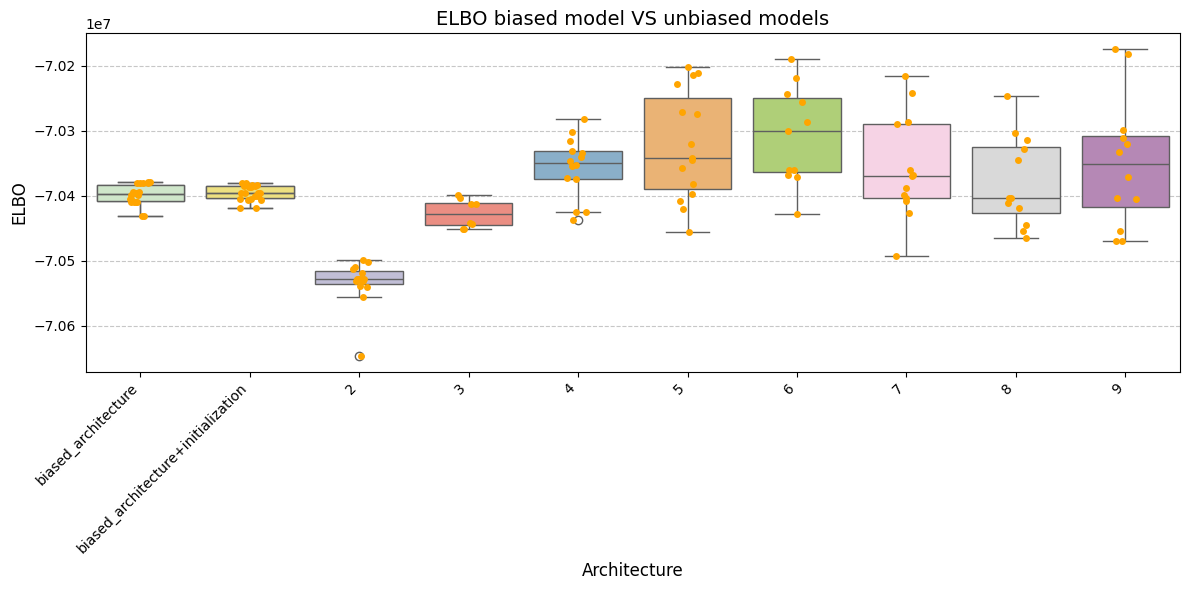

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Add a new column for grouping
def group_model(row):
    if row["architecture"] == "biased_architecture":
        return "biased_architecture"
    elif row["architecture"] == "biased_architecture+initialization":
        return "biased_architecture+initialization"
    else:
        return f"{row['number_of_effects']}"

all_scores["group"] = all_scores.apply(group_model, axis=1)

# Sort the groups to ensure consistent ordering
group_order = (
    ["biased_architecture", "biased_architecture+initialization"] +
    sorted([g for g in all_scores["group"].unique()]))


# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )
# adding data points 
sns.stripplot(data=all_scores, x="group", y="elbo", order=group_order, color='orange') 
# Add labels and title
plt.xlabel("Architecture", fontsize=12)
plt.ylabel("ELBO", fontsize=12)
plt.title("ELBO biased model VS unbiased models", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
selected_groups = ["biased_architecture", "biased_architecture+initialization", "3"]  # Replace with your group names
subset_scores = all_scores[all_scores["group"].isin(selected_groups)]

In [ ]:
from scikit_posthocs import posthoc_dunn

posthoc = posthoc_dunn(subset_scores, val_col="elbo", group_col="group", p_adjust="fdr_bh")
posthoc

,3,biased_initialization_biased_model,unbiased_initialization_biased_model
3,1.000000,0.012446,0.012446
biased_initialization_biased_model,0.012446,1.000000,0.913415
unbiased_initialization_biased_model,0.012446,0.913415,1.000000


### repeat comparison biased_architecture vs unbiased models with 3 effects

In [ ]:
_, model_dict = latenta_processes_basic(base_model, optimizer, "base_model", "base_model_0_0", 1000)
base_model = model_dict["base_model_0_0"][0]

In [ ]:
scores, all_model_dict_per_generation, lineages = model_testing_genetic_algorithm(base_model, optimizer, "base_model", n_model_repeats=1, training_iterations=3000,
                          n_starting_population=20, algorithm_iterations=1, initialization_funcs=initialization_funcs, placeholder=placeholder, n_effects_range=3)

In [ ]:
safe_pickle(all_model_dict_per_generation, "model_dict.pkl", "3_effects_unbiased")
safe_pickle(scores, "scores.pkl", "3_effects_unbiased")

Successfully saved to 3_effects_unbiased/model_dict.pkl
Successfully saved to 3_effects_unbiased/scores.pkl


In [ ]:
with open("biased_models/scores.pkl", "rb") as f:
    scores = pickle.load(f)
with open("biased_models/model_dict.pkl", "rb") as f:
    model_dict = pickle.load(f)

In [ ]:
with open("3_effects_unbiased/scores.pkl", "rb") as f:
    unbiased_scores = pickle.load(f)
with open("3_effects_unbiased/model_dict.pkl", "rb") as f:
    unbiased_dictionary = pickle.load(f)

In [ ]:
scores_unbiased_biased_model = scores[scores["architecture"] == "unbiased_initialization_biased_model"]
scores_unbiased_biased_model["initialisation"] = "unbiased_initialization"
scores_biased_biased_model = scores[scores["architecture"] == "biased_initialization_biased_model"]
scores_biased_biased_model["initialisation"] = "biased_initialization"

/tmp/ipykernel_4056772/1348490208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_unbiased_biased_model["initialisation"] = "unbiased_initialization"
/tmp/ipykernel_4056772/1348490208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_biased_biased_model["initialisation"] = "biased_initialization"


In [ ]:
scores_unbiased_biased_model["architecture"] = "biased_architecture"
scores_biased_biased_model["architecture"] = "biased_architecture+initialization"

/tmp/ipykernel_4056772/3138200098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_unbiased_biased_model["architecture"] = "biased_architecture"
/tmp/ipykernel_4056772/3138200098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_biased_biased_model["architecture"] = "biased_architecture+initialization"


In [ ]:
biased_model_scores = pd.concat([scores_unbiased_biased_model,scores_biased_biased_model], axis=0, ignore_index=True)

In [ ]:
all_scores = pd.concat([biased_model_scores,unbiased_scores], axis=0, ignore_index=True)

In [ ]:
all_scores = all_scores.drop(columns=['index',	'generation',	'relative_elbo',	'relative_lik',	'relative_penalty'])

In [ ]:
# Apply the function to create the new column
all_scores["number_of_effects"] = all_scores["architecture"].apply(count_effects)

/tmp/ipykernel_4056772/1681359359.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )


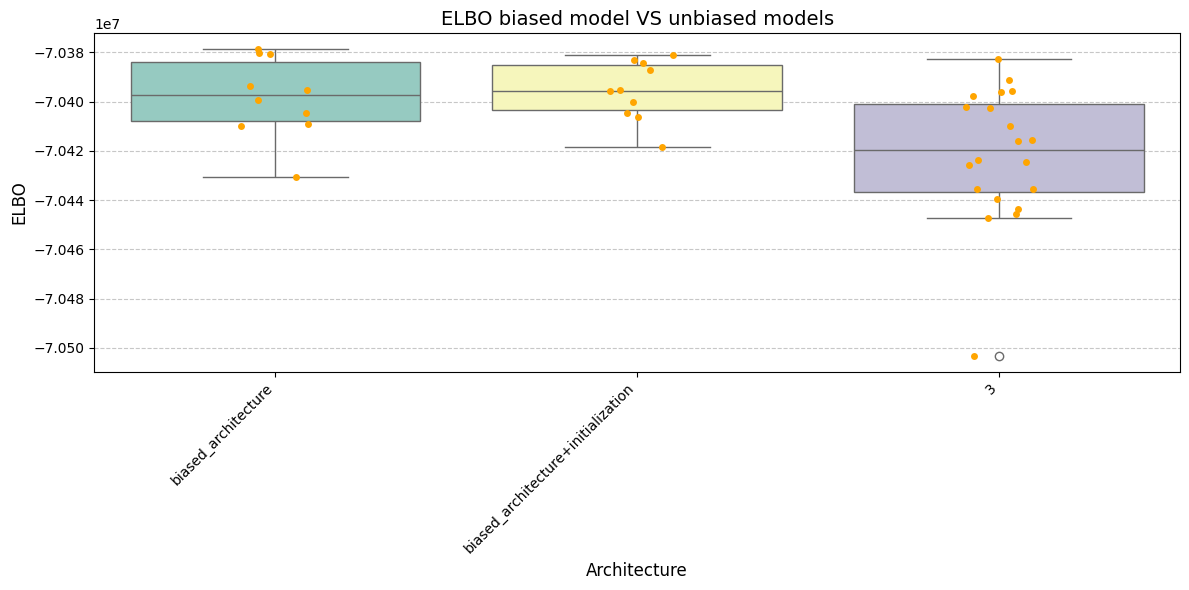

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Add a new column for grouping
def group_model(row):
    if row["architecture"] == "biased_architecture":
        return "biased_architecture"
    elif row["architecture"] == "biased_architecture+initialization":
        return "biased_architecture+initialization"
    else:
        return f"{row['number_of_effects']}"

all_scores["group"] = all_scores.apply(group_model, axis=1)

# Sort the groups to ensure consistent ordering
group_order = (
    ["biased_architecture", "biased_architecture+initialization"] +
    sorted(
        [g for g in all_scores["group"].unique() 
         if g not in ["biased_architecture", "biased_architecture+initialization"]]
    )
)

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_scores, x="group", y="elbo", order=group_order, palette="Set3", )
# adding data points 
sns.stripplot(data=all_scores, x="group", y="elbo", order=group_order, color='orange') 
# Add labels and title
plt.xlabel("Architecture", fontsize=12)
plt.ylabel("ELBO", fontsize=12)
plt.title("ELBO biased model VS unbiased models", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()